# Yellow Taxi Data Analysis

## Source Data
The NYC Taxi and Limousine Commission (TLC) publicly shares data on trips taken by Yellow taxis, Green taxis, and “For-Hire-Vehicles” (FHVs).  

In this excercise, we only consider trips taken by **Yellow taxis in June 2017**.
  
## Exercise

Imagine that you decide to drive a taxi for 10 hours each week to earn a little extra money. Explain how you would approach maximizing your income as a taxi driver.
If you could enrich the dataset, what would you add?  Is there anything in the dataset that you don’t find especially useful?

[Click here to jump to CONCLUSION](#Conclusion)

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from scipy import stats
from copy import deepcopy
import warnings

warnings.filterwarnings('ignore')

%reload_ext autoreload
%autoreload 2
%matplotlib inline

sns.set(style="darkgrid")

Load the data and briefly check the dimension of the data, columns names and data types.

In [2]:
data = pd.read_csv('../data/processed/yellow_taxi_data.csv')

data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,pickup_weekday,pickup_month,pickup_day,pickup_hr,dropoff_weekday,dropoff_month,dropoff_day,dropoff_hr,trip_duration,driver_received_amount
0,2,2017-06-08 07:52:31,2017-06-08 08:01:32,6,1.03,1,N,161,140,1,...,3,6,8,7,3,6,8,8,9.016667,9.36
1,2,2017-06-08 08:08:18,2017-06-08 08:14:00,6,1.03,1,N,162,233,1,...,3,6,8,8,3,6,8,8,5.700000,8.34
2,2,2017-06-08 08:16:49,2017-06-08 15:43:22,6,5.63,1,N,137,41,2,...,3,6,8,8,3,6,8,15,446.550000,21.50
3,2,2017-06-29 15:52:35,2017-06-29 16:03:27,6,1.43,1,N,142,48,1,...,3,6,29,15,3,6,29,16,10.866667,9.38
4,1,2017-06-01 00:00:00,2017-06-01 00:03:43,1,0.60,1,N,140,141,1,...,3,6,1,0,3,6,1,0,3.716667,6.50


In [3]:
data.shape

(9656993, 33)

In [4]:
data.dtypes

VendorID                    int64
tpep_pickup_datetime       object
tpep_dropoff_datetime      object
passenger_count             int64
trip_distance             float64
RatecodeID                  int64
store_and_fwd_flag         object
PULocationID                int64
DOLocationID                int64
payment_type                int64
fare_amount               float64
extra                     float64
mta_tax                   float64
tip_amount                float64
tolls_amount              float64
improvement_surcharge     float64
total_amount              float64
PUBorough                  object
PUZone                     object
PUservice_zone             object
DOBorough                  object
DOZone                     object
DOservice_zone             object
pickup_weekday              int64
pickup_month                int64
pickup_day                  int64
pickup_hr                   int64
dropoff_weekday             int64
dropoff_month               int64
dropoff_day   

Convert to correct data types

In [5]:
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])
data[['VendorID', 'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type']] = \
data[['VendorID', 'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type']].astype(str)

## Data Quality Inspection

### Unrelated data 
   - Drop payment_type equals to "No Charge"(3), "Dispute"(4), and "Voided trip"(6) because we should be only interested in "valid trips" which generate incomes
   - Drop Rate Code ID that is not in data dictionary


In [6]:
valid_data = data[~data['payment_type'].isin(['3', '4', '6'])]
valid_data = valid_data[valid_data['RatecodeID'] != '99']

- Drop data points with Unknown PUBorough

In [7]:
valid_data = valid_data[valid_data['PUBorough'] != 'Unknown']

What determines the worth of the trip is its duration and the amount the driver receives.
So we will start with the statistics from `describe()`.

Since `valid_data` does not contain any payment_type=3, 4, and 6 we should expect to see driver_recieved_amount columns to have only positive values. However, we can still see negative values from the table below.

Even if the rate is negotiated, it's unreasonable to think that taxi driver will take a ride resulting negative amounts. Thus we assume the negative values are either records with data quality issues or some other reasons 
and we should drop them.

In [8]:
round(valid_data[['trip_distance', 'trip_duration', 'fare_amount',
                  'tip_amount', 'driver_received_amount']].describe(), 2)

,trip_distance,trip_duration,fare_amount,tip_amount,driver_received_amount
count,9450549.00,9450549.00,9450549.00,9450549.00,9450549.00
mean,2.98,16.91,13.25,1.89,15.13
std,5.73,55.47,217.42,2.65,217.52
min,0.00,0.00,-52.00,0.00,-52.00
25%,1.00,6.73,6.50,0.00,7.50
50%,1.68,11.30,9.50,1.36,10.96
75%,3.10,18.68,15.00,2.46,17.00
max,9496.98,14407.65,630461.82,444.00,630461.82


In [9]:
valid_data = valid_data[valid_data['driver_received_amount'] > 0]

### Outlier Detection and Removal
We might also want to do an outlier analysis to exclude trips with *extrem durations/amounts* that don't happen as 
often, such as trips with fat tips or incredible long trip durations(distances)

Use `Z-Score` and `threshold=3` to excldue outliers

Here we create `valid_data_` as a copy of current working valid_data to do outlier detection and removal 
before make it the actual working data frame.

In [10]:
valid_data_ = deepcopy(valid_data)

valid_data_['tip_z_score'] = stats.zscore(valid_data['tip_amount'])
valid_data_['fare_z_score'] = stats.zscore(valid_data['fare_amount'])
valid_data_['duration_z_score'] = stats.zscore(valid_data['trip_duration'])
valid_data_['distance_z_score'] = stats.zscore(valid_data['trip_distance'])

valid_data_ = valid_data_[(valid_data_['tip_z_score'].between(-3, 3)) & 
                          (valid_data_['duration_z_score'].between(-3, 3)) &
                          (valid_data_['distance_z_score'].between(-3, 3)) &
                          (valid_data_['fare_z_score'].between(-3, 3))]

After removing the outliers

In [11]:
round(valid_data_[['trip_distance', 'trip_duration', 'fare_amount', 'tip_amount', 'driver_received_amount']].describe(), 2)


,trip_distance,trip_duration,fare_amount,tip_amount,driver_received_amount
count,9179145.00,9179145.00,9179145.00,9179145.00,9179145.00
mean,2.61,13.85,12.06,1.61,13.68
std,2.89,10.66,8.93,1.79,9.86
min,0.00,0.00,0.00,0.00,0.01
25%,1.00,6.63,6.50,0.00,7.50
50%,1.60,11.03,9.50,1.35,10.54
75%,2.90,17.85,14.00,2.35,16.00
max,20.15,183.27,644.50,9.83,644.50


In [12]:
print("We have {}% of raw dataset for the analysis".format(round(len(valid_data_)*100/len(data)), 2))

We have 95% of raw dataset for the analysis


In [13]:
valid_data = valid_data_

## Exploratory Data Analysis

### Standard Rate vs. Negotiated Rate

* 1= Standard rate
* 2=JFK
* 3=Newark
* 4=Nassau or Westchester
* 5=Negotiated fare
* 6=Group ride

The majority of Rate Code ID in all Pick-Up Boroughs except are Standard Rate except for ***EWR*** where Rate Code ID is mainly ***Negotiated***.

In [14]:
rateid_cnt = valid_data.groupby(['PUBorough', 'RatecodeID']).size()

rateid_pct = rateid_cnt.groupby(level=0).apply(lambda x:
                                               100 * x / float(x.sum()))

pd.concat([rateid_cnt, rateid_pct], axis=1, sort=False).rename(columns={0: 'count', 1: 'pct'})

count        pct
PUBorough     RatecodeID                    
Bronx         1              7321  95.711858
              2                44   0.575239
              3                13   0.169957
              4                21   0.274546
              5               250   3.268401
Brooklyn      1            145091  99.153961
              2               268   0.183149
              3                63   0.043054
              4                48   0.032803
              5               858   0.586350
              6                 1   0.000683
EWR           1                29   9.897611
              2                 6   2.047782
              3                11   3.754266
              5               246  83.959044
              6                 1   0.341297
Manhattan     1           8529656  99.451850
              2             31461   0.366821
              3              6117   0.071321
              4               389   0.004536
              5              9028   0.105262
              6                18   0.000210
Queens        1            393205  87.747428
              2             50403  11.247908
              3               366   0.081676
              4              1793   0.400125
              5              2328   0.519515
              6                15   0.003347
Staten Island 1                66  69.473684
              2                 1   1.052632
              5                28  29.473684

### Daily Number of Pickups by Boroughs
Manhattan accounts for the largest number of taxi pickups of any borough in any given day of June, 2017.

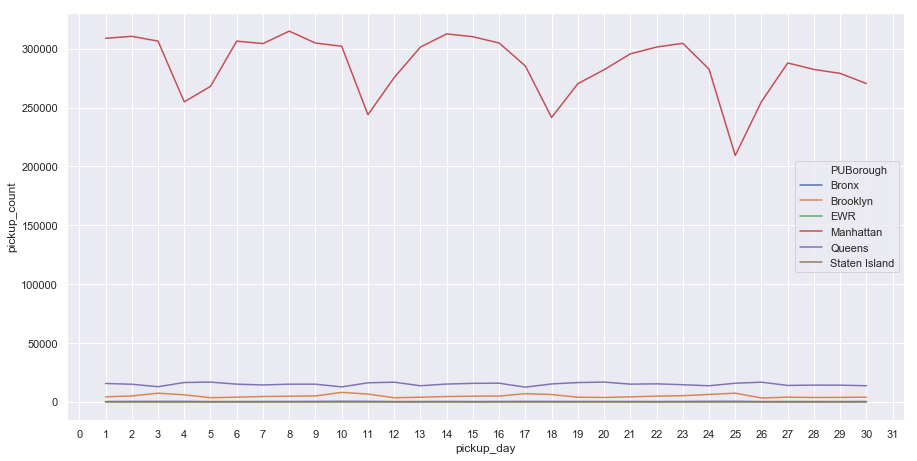

In [15]:
plot_df = valid_data.groupby(['pickup_day', 'PUBorough'])['tpep_pickup_datetime']\
.count().reset_index().rename(columns={'tpep_pickup_datetime': 'pickup_count'})


fig, ax = plt.subplots(figsize=(15, 7.5))
ax = sns.lineplot(x='pickup_day', y='pickup_count', hue='PUBorough', data=plot_df)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

plt.show()

### Number of Pickups by Boroughs and Hour of the Day/Weekday

We can see that there's trend of number of pickups throughout the day especially in Manhattan, where the most of the pickups happen. The peak hours are generally from **6PM to 10PM on weekdays** and are **during lunch hours, dinner hours, and around 10PM-11PM on weekends**.

Surprisingly, Saturday actually has slightly less volume of trips than trips on Wednesday, Thursday, and Friday.

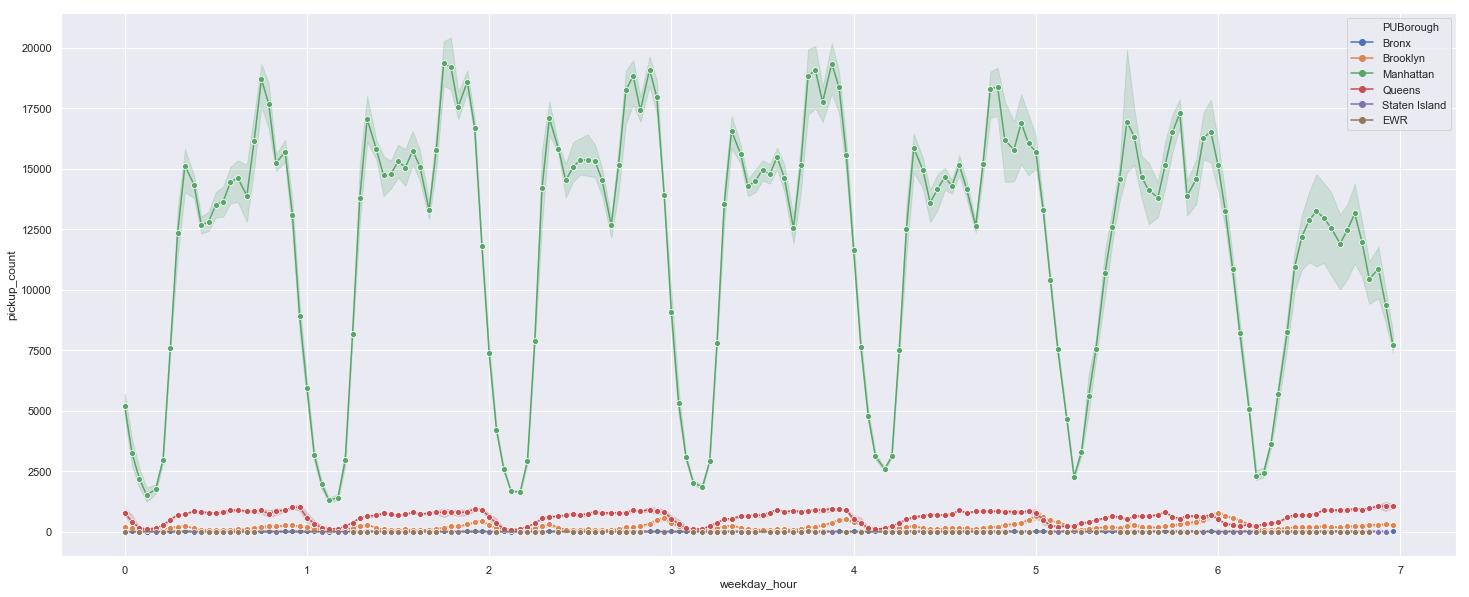

In [16]:
plot_df = valid_data.groupby(['pickup_day', 'pickup_weekday', 'pickup_hr', 'PUBorough'])['tpep_pickup_datetime']\
.count().reset_index().rename(columns={'tpep_pickup_datetime': 'pickup_count'})

plot_df['weekday_hour'] = round(plot_df['pickup_weekday'] + (plot_df['pickup_hr']/24), 2)

fig, ax = plt.subplots(figsize=(25, 10))
ax = sns.lineplot(x='weekday_hour', y='pickup_count', hue='PUBorough', style="PUBorough", data=plot_df, 
                  markers=['o'] * len(plot_df['PUBorough'].unique()), dashes=False)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

plt.show()


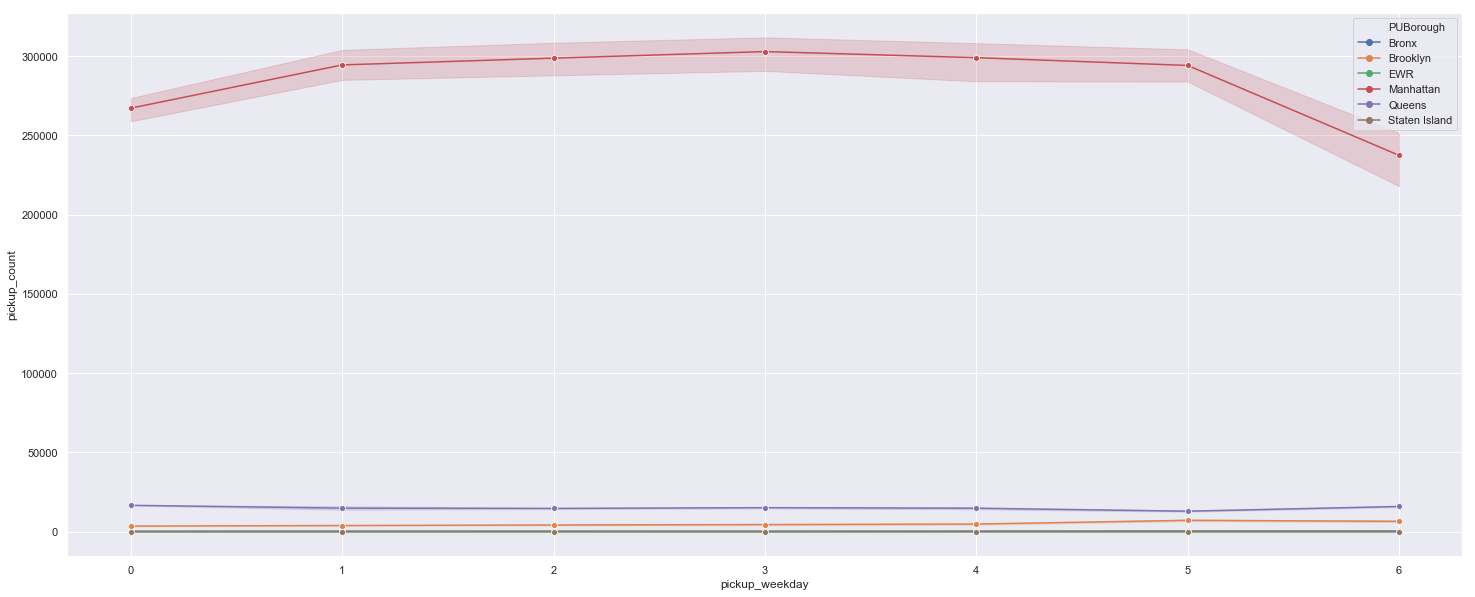

In [17]:
plot_df = valid_data.groupby(['pickup_day', 'pickup_weekday', 'PUBorough'])['tpep_pickup_datetime']\
.count().reset_index().rename(columns={'tpep_pickup_datetime': 'pickup_count'})

fig, ax = plt.subplots(figsize=(25, 10))
ax = sns.lineplot(x='pickup_weekday', y='pickup_count', hue='PUBorough', style="PUBorough", data=plot_df, 
                  markers=['o'] * len(plot_df['PUBorough'].unique()), dashes=False)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

plt.show()

### Trip Duration by Boroughs and Hour of the day/weekday
* 0=Monday
* 1=Tuesday
* 2=Wednesday
* 3=Thursday
* 4=Friday
* 5=Saturday
* 6=Sunday

Other than Staten Island and EWR that have very high variance through out the week, in boroughs like Manhattan, Queens, Brooklyn, and Bronx, they do have daily trend of the trip duration which could be caused by the traffic situations, different road systems, and various reasons. One particular observation is that amoung the 4 buroughs, **trips from Queens tend to be taking longer than trips from other boroughs**.

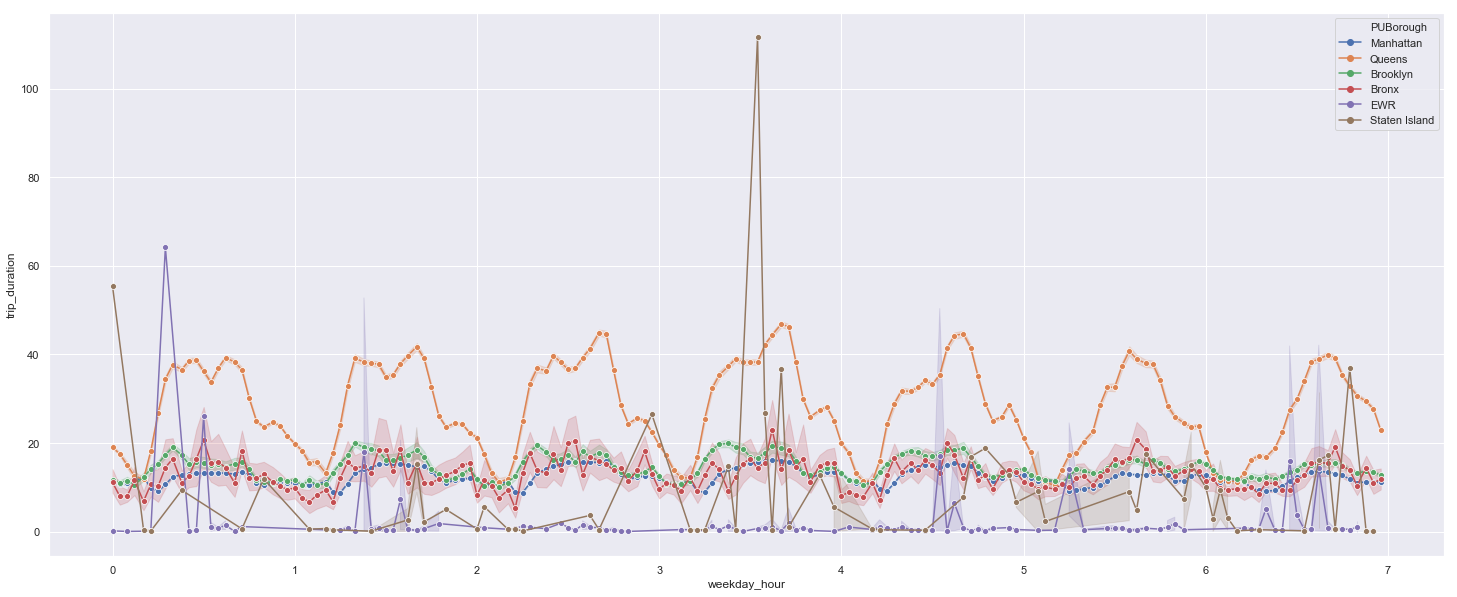

In [18]:
trip_duration_df = valid_data[['pickup_day', 'pickup_weekday', 'pickup_hr', 'PUBorough', 'trip_duration']]

trip_duration_df['weekday_hour'] = round(trip_duration_df['pickup_weekday'] + (trip_duration_df['pickup_hr']/24), 2)

fig, ax = plt.subplots(figsize=(25, 10))
ax = sns.lineplot(x='weekday_hour', y='trip_duration', hue='PUBorough', style="PUBorough", data=trip_duration_df, 
                  markers=['o'] * len(plot_df['PUBorough'].unique()), dashes=False)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

plt.show()


### Average Hourly Rate by Borough and Hour of the day/weekday

If we want to know how to best spend the driving hours and to have best hourly pay, we can see that the trips from EWR ususally have higher hourly return than trips from other boroughs, which can be because of - 
* The airport is further away from the metropolitan area which is usually people are headed to
* Passengers are more willing to tip the drivers for moving their luggages
* Price are negotiated so it can be more profitable to the driver than the standard rates

In [19]:
kpi_calc_df = valid_data[['pickup_day', 'pickup_weekday', 'pickup_hr', 'PUBorough',
                          'driver_received_amount', 'trip_duration', 'tpep_pickup_datetime']]

kpi_calc_df['weekday_hour'] = round(kpi_calc_df['pickup_weekday'] + (kpi_calc_df['pickup_hr']/24), 2)

kpi_calc_df = kpi_calc_df.groupby(['pickup_day', 'weekday_hour' , 'PUBorough']).agg({'driver_received_amount': 'sum',
                                                                                     'trip_duration': ['sum', 'mean', 'median']
                                                                                    })

kpi_calc_df.reset_index(inplace=True)

kpi_calc_df.columns = kpi_calc_df.columns.get_level_values(1).values + ' ' + kpi_calc_df.columns.get_level_values(0).values
kpi_calc_df.columns = [v.strip() for v in kpi_calc_df.columns.values]

kpi_calc_df['average_hr_rate'] = kpi_calc_df['sum driver_received_amount']*60 / kpi_calc_df['sum trip_duration']

kpi_calc_df = kpi_calc_df.replace([np.inf, -np.inf], np.nan).dropna()

kpi_calc_df.drop(['sum driver_received_amount', 'sum trip_duration'], axis=1, inplace=True)


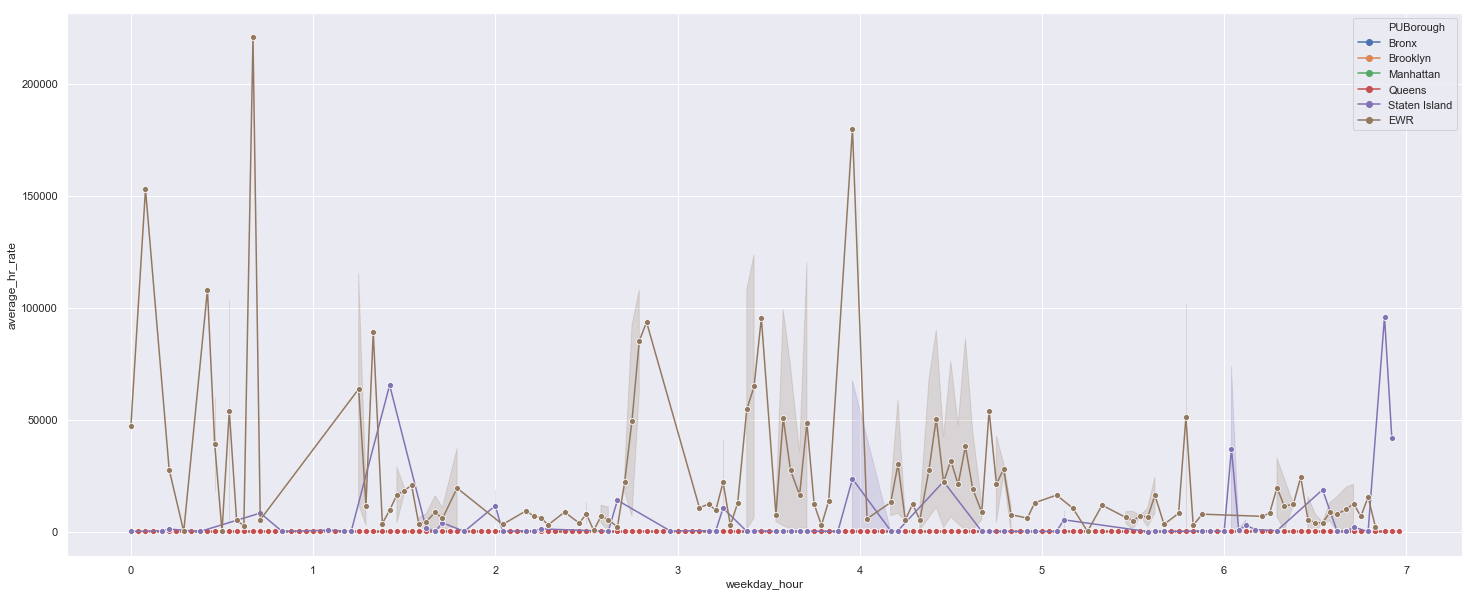

In [20]:
fig, ax = plt.subplots(figsize=(25, 10))
ax = sns.lineplot(x='weekday_hour', y='average_hr_rate', hue='PUBorough', style="PUBorough", data=kpi_calc_df, 
                  markers=['o'] * len(kpi_calc_df['PUBorough'].unique()), dashes=False)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

plt.show()

### Although EWR Shows the Highest Hourly Rate
When we combine the metrics that we evaluated, although EWR shows the best hourly rate, it actually doesn't have as many trips recorded as other metropolitan boroughs(Manhattan/Brooklyn/Queens/Bronx). Taking "demand" and the distance to/from the airport into account, it might not be the best practice to only takes trips from the EWR airport because the driver might ended up waiting for new passenger in line and making as much money.

In [21]:
pickup_cnt_df = valid_data.groupby(['pickup_day', 'pickup_weekday', 'pickup_hr', 'PUBorough'])['tpep_pickup_datetime']\
.count().reset_index().rename(columns={'tpep_pickup_datetime': 'pickup_count'})

pickup_cnt_df['weekday_hour'] = round(pickup_cnt_df['pickup_weekday'] + (pickup_cnt_df['pickup_hr']/24), 2)


combined_eval_df = kpi_calc_df.merge(pickup_cnt_df, on=['pickup_day', 'weekday_hour', 'PUBorough'])

In [22]:
combined_eval_df.groupby('PUBorough')[['average_hr_rate', 'mean trip_duration',
                                       'median trip_duration', 'pickup_count']].describe().transpose()

PUBorough                        Bronx    Brooklyn            EWR  \
average_hr_rate      count  718.000000  720.000000     201.000000   
                     mean    74.862227   65.236557   21891.879443   
                     std     35.649325    9.814901   34481.774620   
                     min     35.714719   46.152466       5.263158   
                     25%     57.001844   57.719596    3908.219178   
                     50%     66.650180   63.514240    9337.500000   
                     75%     79.192148   71.774774   19028.571429   
                     max    538.515901  134.862542  220800.000000   
mean trip_duration   count  718.000000  720.000000     201.000000   
                     mean    12.868591   14.550855       2.644863   
                     std      4.802114    2.781651       9.856558   
                     min      1.108333    9.400585       0.033333   
                     25%      9.636310   12.293308       0.200000   
                     50%     12.390694   14.146414       0.472222   
                     75%     15.459028   16.533757       0.883333   
                     max     42.444444   24.718438      87.483333   
median trip_duration count  718.000000  720.000000     201.000000   
                     mean    10.733264   12.396157       2.391335   
                     std      4.579016    2.377259       9.511855   
                     min      0.183333    7.800000       0.033333   
                     25%      7.920833   10.595833       0.200000   
                     50%     10.095833   11.983333       0.466667   
                     75%     12.945833   13.770833       0.833333   
                     max     44.066667   23.200000      87.483333   
pickup_count         count  718.000000  720.000000     201.000000   
                     mean    10.653203  203.234722       1.452736   
                     std      5.537075  143.797277       0.747666   
                     min      1.000000   44.000000       1.000000   
                     25%      7.000000   95.000000       1.000000   
                     50%     10.000000  162.500000       1.000000   
                     75%     13.750000  251.000000       2.000000   
                     max     39.000000  908.000000       5.000000   

PUBorough                      Manhattan       Queens  Staten Island  
average_hr_rate      count    720.000000   720.000000      79.000000  
                     mean      63.182643    71.891655    6204.953643  
                     std       10.277157    15.730737   17557.794184  
                     min       49.253106    45.900342       0.019078  
                     25%       54.390547    58.018431      82.301229  
                     50%       60.909702    68.480144     381.818182  
                     75%       71.672895    85.917233    1131.465517  
                     max       88.503080   123.303600   96000.000000  
mean trip_duration   count    720.000000   720.000000      79.000000  
                     mean      12.441619    27.967933       8.295868  
                     std        1.963210    10.243114      15.776754  
                     min        8.513867     8.693202       0.050000  
                     25%       10.934771    19.295465       0.425000  
                     50%       12.299549    28.483574       0.841667  
                     75%       13.956279    36.660229      10.975000  
                     max       17.071878    51.612173     111.616667  
median trip_duration count    720.000000   720.000000      79.000000  
                     mean      10.329248    28.100729       8.246941  
                     std        1.704663    11.581157      15.781683  
                     min        6.433333     7.833333       0.050000  
                     25%        9.122917    18.845833       0.425000  
                     50%       10.300000    27.704167       0.800000  
                     75%       11.591667    38.135417      10.975000  
                  

## Conclusion

### Weekly Schedule

Based on the data that we have, it is save to say that driver should drive around Manhattan to pickup passengers because that is the most volume of trips coming from and with higher chance of making trips with less waiting time in between passengers. Depending on how the driver's weekly schedule is, it's highly recommended to drive between 6pm - 10pm from Wednesday to Friday and during those peak hours (lunch/dinner hours and 10pm-11pm) on Saturdays. On top of that, maybe drive around the airport during the weekends because there are less trips in the city. Or if there is a chance of dropping off someone around EWR airport area, it'd be probably worth spend sometime waiting in line to pick up people from the airport for higher hourly return since the driver is already around that area.

If I were to set a weekly 10-hour driving schedule, it would be - 
* Monday 6PM - 7PM (1 Hour) in Manhattan
* Tuesday 6PM - 7PM (1 Hour) in Manhattan
* Wednesday 6PM - 7PM & 9PM - 10PM (2 Hours) in Manhattan
* Thursday 6PM - 7PM & 9PM - 10PM (2 Hours) in Manhattan
* Friday 6PM - 7PM (1 Hour) in Manhattan
* Saturday - start driving around lunch time in Manhattan and try to get trips to EWR airport for 3 hours or just spend the 3 hours in EWR for higher pay depending the waiting time in line to get passenger leaving the airport.


### Suggestions

What improvement can be done - 
* Correlation between number of trips/durations/hourly rate and not just Pickup Borough but Dropoff Borough as well
* Deeper analysis into Zones besides boroughs
* Wider time frame and more data
* Different type of data as listed below, e.g. competitor and cost data, to have a more holistic viewpoint.

From learning the data and doing the analysis, I find these fields don't have much value when it comes to optimizing a driver's schedule and pay.
* VendorID
* passenger_count
* store_and_fwd_flag


To make the analysis to be more complete, I'd want to bring in these datasets - 

* Taxi data or counts around each hour to have better understanding about the supply (number of taxi) and demand (number of trips)
* Cost data - what is the cost of completing each trip, e.g. fuel price, maintenence cost, waiting time in-between trips
* Competitor data - assuming Uber or Lyft are the competitors of the yellow taxi, what do Uber/Lyft trips look like? How can a yellow driver come up the best strategy to compete with Uber/Lyft drivers?
